<a href="https://colab.research.google.com/github/Fabioaugustmp/ml-politicas-energeticas-ifg-2025/blob/main/CC_ML_TRAINING_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas shapely fiona pyproj boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.spatial import cKDTree
import pandas as pd
from scipy.spatial import cKDTree
import boto3
from botocore.client import Config
import io
from botocore import UNSIGNED
import requests
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

Passo 1: Preparação da Base Geoespacial (Microrregiões)
Considerações:
Aqui, construímos a fundação do nosso dataset. Cada linha representará uma microrregião de Goiás, que é a nossa unidade de análise.

Leitura dos Dados: Carregamos o arquivo shapefile que contém os polígonos (as formas geométricas) de cada microrregião.

Limpeza e Seleção: Renomeamos as colunas para um padrão mais limpo e selecionamos apenas as informações essenciais: código, nome e a geometria.

Cálculos Geométricos:

Área: Para calcular a área em km², primeiro convertemos a projeção geográfica (graus) para uma projeção métrica (UTM). Isso garante que o cálculo da área seja preciso.

Centroide: Calculamos o ponto central de cada microrregião. Essas coordenadas serão cruciais para associar dados pontuais, como os das estações meteorológicas.

In [ ]:
# ====================================================================================
# PASSO 1 (VERSÃO FINAL CORRIGIDA): CARREGAR E PREPARAR DADOS DOS MUNICÍPIOS
# ====================================================================================

# Carregue o shapefile dos Municípios de Goiás a partir da URL.
# Este arquivo contém os polígonos de cada município.
gdf_municipios = gpd.read_file('https://ml-politicas-energeticas.s3.us-east-2.amazonaws.com/GO-MICROREGIOES/GO_Municipios_2024.shp')


# --- INSPEÇÃO E LIMPEZA ---
# Vamos inspecionar as colunas para usar os nomes corretos.
print("Nomes originais das colunas do arquivo de municípios:")
print(gdf_municipios.columns)
print("-" * 50)

# Renomeia as colunas de municípios para um padrão limpo (ajuste se os nomes forem diferentes).
# Os nomes comuns são 'CD_MUN' e 'NM_MUN'.
gdf_municipios = gdf_municipios.rename(columns={
    'CD_MUN': 'cd_mun',
    'NM_MUN': 'nm_mun'
})

# Seleciona apenas as colunas de interesse para manter o DataFrame organizado.
# A partir de agora, nossa análise será por MUNICÍPIO.
df_base = gdf_municipios[['cd_mun', 'nm_mun', 'geometry']].copy()


# --- CÁLCULO PRECISO DA ÁREA E DO CENTROIDE ---

# Define o CRS projetado ideal para Goiás (SIRGAS 2000 / UTM zone 22S) para cálculos em metros.
projected_crs = 'EPSG:31982'

# 1. Calcula a área em km², usando a projeção correta para precisão.
df_base['area_km2'] = df_base['geometry'].to_crs(projected_crs).area / 10**6

# 2. Calcula o centroide da forma precisa para EVITAR O WARNING:
#    a. Projeta a geometria para o sistema de metros (UTM).
#    b. Calcula o centroide nesse sistema.
#    c. Converte o ponto do centroide de volta para o sistema geográfico de lat/lon (WGS84).
centroids_geographic = df_base['geometry'].to_crs(projected_crs).centroid.to_crs(df_base.crs)

# 3. Extrai as coordenadas de longitude e latitude do centroide já re-convertido.
df_base['centroid_lon'] = centroids_geographic.x
df_base['centroid_lat'] = centroids_geographic.y

print("\n--- Base de Municípios Pronta (sem avisos) ---")
print(df_base.head())

Nomes originais das colunas do arquivo de municípios:
Index(['CD_MUN', 'NM_MUN', 'CD_RGI', 'NM_RGI', 'CD_RGINT', 'NM_RGINT', 'CD_UF',
       'NM_UF', 'SIGLA_UF', 'CD_REGIA', 'NM_REGIA', 'SIGLA_RG', 'CD_CONCU',
       'NM_CONCU', 'AREA_KM2', 'geometry'],
      dtype='object')
--------------------------------------------------

--- Base de Municípios Pronta (sem avisos) ---
    cd_mun                  nm_mun  \
0  5219902  São Francisco de Goiás   
1  5215652      Palestina de Goiás   
2  5208400             Goianápolis   
3  5207105                 Diorama   
4  5218607                  Rialma   

                                            geometry     area_km2  \
0  POLYGON ((-49.29477 -16.00852, -49.29484 -16.0...   416.562255   
1  POLYGON ((-51.66518 -16.85357, -51.66522 -16.8...  1317.068866   
2  POLYGON ((-48.99706 -16.48599, -48.99716 -16.4...   166.684000   
3  POLYGON ((-51.17175 -16.18246, -51.17179 -16.1...   684.862390   
4  POLYGON ((-49.58194 -15.32987, -49.58211 -15.3..

Passo 2: Processar e Agregar os Dados das Usinas (ANEEL)
Considerações:
O objetivo desta etapa é transformar os dados brutos das usinas (pontos em um mapa) em informações úteis para cada microrregião (nossas linhas do DataFrame).

Carregamento e Filtragem: Carregamos os dados da ANEEL e filtramos para manter apenas as usinas em operação no estado de Goiás.

Limpeza de Dados: As coordenadas e a potência vêm como texto com vírgulas. Convertemos essas colunas para um formato numérico para que possam ser usadas em cálculos.

Conversão para GeoDataFrame: Transformamos o DataFrame do pandas em um GeoDataFrame, criando um objeto Point para cada par de coordenadas (latitude/longitude).

Junção Espacial (sjoin): Esta é a operação mais importante aqui. Cruzamos espacialmente as usinas e as microrregiões. O resultado nos diz exatamente a qual microrregião cada usina pertence.

Agregação: Com a junção feita, usamos groupby() para calcular, por microrregião:

O número total de usinas.

O número específico de usinas solares (UFV).

A soma total da potência instalada (convertida para Megawatts).

Merge Final: Unimos essas novas informações ao nosso DataFrame principal. Usamos fillna(0) para garantir que microrregiões sem nenhuma usina registrada recebam o valor zero em vez de NaN (nulo).

In [ ]:
# ============================================================================================
# PASSO 2 (VERSÃO FINAL E CORRIGIDA COM BASE NO DICIONÁRIO DE DADOS)
# ============================================================================================

# Carregue os dados da ANEEL diretamente da fonte oficial.
url_aneel = 'https://ml-politicas-energeticas.s3.us-east-2.amazonaws.com/ANEEL-SIGA-SISTEMAS-DE-INFORMA%C3%87%C3%83O-GERA%C3%87%C3%83O/siga-empreendimentos-geracao.csv'
df_usinas = pd.read_csv(url_aneel, encoding='ISO-8859-1', sep=';')

# --- ETAPA DE DIAGNÓSTICO ---
print("--- Nomes das Colunas do Arquivo da ANEEL ---")
# O nome correto da coluna de fase, de acordo com o dicionário, é 'DscFaseUsina'
print(df_usinas.columns)
print("-" * 50)

# --- CORREÇÃO APLICADA AQUI ---
# Filtra usando as colunas corretas: 'SigUFPrincipal' e 'DscFaseUsina' para a fase de operação.
# Este filtro é essencial para obter resultados corretos.
df_usinas_go = df_usinas[
    (df_usinas['SigUFPrincipal'] == 'GO') &
    (df_usinas['DscFaseUsina'] == 'Operação')
].copy()

# Converte as colunas de coordenadas e potência para formato numérico.
df_usinas_go['latitude'] = pd.to_numeric(df_usinas_go['NumCoordNEmpreendimento'].str.replace(',', '.'), errors='coerce')
df_usinas_go['longitude'] = pd.to_numeric(df_usinas_go['NumCoordEEmpreendimento'].str.replace(',', '.'), errors='coerce')
df_usinas_go['potencia_kw'] = pd.to_numeric(df_usinas_go['MdaPotenciaFiscalizadaKw'], errors='coerce')

# Remove usinas que não possuem coordenadas ou potência válidas.
df_usinas_go.dropna(subset=['latitude', 'longitude', 'potencia_kw'], inplace=True)

# Converte o DataFrame de usinas em um GeoDataFrame para operações espaciais.
geometry = [Point(xy) for xy in zip(df_usinas_go['longitude'], df_usinas_go['latitude'])]
gdf_usinas_go = gpd.GeoDataFrame(df_usinas_go, crs='EPSG:4326', geometry=geometry)

# Garante que ambos os GeoDataFrames usem o mesmo CRS antes da junção.
gdf_usinas_go = gdf_usinas_go.to_crs(df_base.crs)

# --- Agregação dos Dados por MUNICÍPIO ---
# Realiza a junção espacial.
gdf_usinas_por_municipio = gpd.sjoin(gdf_usinas_go, df_base, how="inner", predicate='within')

# 1. Agrega a contagem total de usinas por município.
usinas_contagem = gdf_usinas_por_municipio.groupby('cd_mun').size().reset_index(name='num_total_usinas')

# 2. Agrega a contagem por tipo, usando a coluna 'SigTipoGeracao' para todos.
usinas_solares_contagem = gdf_usinas_por_municipio[gdf_usinas_por_municipio['SigTipoGeracao'] == 'UFV'].groupby('cd_mun').size().reset_index(name='num_usinas_solares')
usinas_eolica_contagem = gdf_usinas_por_municipio[gdf_usinas_por_municipio['SigTipoGeracao'] == 'EOL'].groupby('cd_mun').size().reset_index(name='num_usinas_eolica')

# 3. Agrega a soma da potência TOTAL (convertida para MW) por município.
usinas_potencia = gdf_usinas_por_municipio.groupby('cd_mun')['potencia_kw'].sum().reset_index()
usinas_potencia.rename(columns={'potencia_kw': 'potencia_total_mw'}, inplace=True)
usinas_potencia['potencia_total_mw'] /= 1000

# 4. ADIÇÃO: Agrega a soma da potência HIDRELÉTRICA, usando 'SigTipoGeracao'.
usinas_hidro = gdf_usinas_por_municipio[
    gdf_usinas_por_municipio['SigTipoGeracao'].isin(['UHE', 'PCH', 'CGH'])
]
potencia_hidro_por_mun = usinas_hidro.groupby('cd_mun')['potencia_kw'].sum().reset_index()
potencia_hidro_por_mun.rename(columns={'potencia_kw': 'potencia_hidro_mw'}, inplace=True)
potencia_hidro_por_mun['potencia_hidro_mw'] /= 1000

# --- Consolidação no DataFrame Final ---
df_final = pd.merge(df_base, usinas_contagem, on='cd_mun', how='left')
df_final = pd.merge(df_final, usinas_solares_contagem, on='cd_mun', how='left')
df_final = pd.merge(df_final, usinas_eolica_contagem, on='cd_mun', how='left')
df_final = pd.merge(df_final, usinas_potencia, on='cd_mun', how='left')
df_final = pd.merge(df_final, potencia_hidro_por_mun, on='cd_mun', how='left')

# Preenche com 0 os municípios que não têm usinas.
df_final.fillna(0, inplace=True)

print("\n--- Base de dados com informações das usinas agregadas por MUNICÍPIO ---")
# Agora você verá valores de potência corretos, e não mais zerados.
print(df_final[['nm_mun', 'potencia_total_mw', 'potencia_hidro_mw']].head())

--- Nomes das Colunas do Arquivo da ANEEL ---
Index(['DatGeracaoConjuntoDados', 'NomEmpreendimento', 'IdeNucleoCEG',
       'CodCEG', 'SigUFPrincipal', 'SigTipoGeracao', 'DscFaseUsina',
       'DscOrigemCombustivel', 'DscFonteCombustivel', 'DscTipoOutorga',
       'NomFonteCombustivel', 'DatEntradaOperacao', 'MdaPotenciaOutorgadaKw',
       'MdaPotenciaFiscalizadaKw', 'MdaGarantiaFisicaKw',
       'IdcGeracaoQualificada', 'NumCoordNEmpreendimento',
       'NumCoordEEmpreendimento', 'DatInicioVigencia', 'DatFimVigencia',
       'DscPropriRegimePariticipacao', 'DscSubBacia', 'DscMuninicpios'],
      dtype='object')
--------------------------------------------------

--- Base de dados com informações das usinas agregadas por MUNICÍPIO ---
                   nm_mun  potencia_total_mw  potencia_hidro_mw
0  São Francisco de Goiás                0.0                0.0
1      Palestina de Goiás                0.0                0.0
2             Goianápolis                0.0                0.

Passo 3: Processar e Agregar os Dados Meteorológicos (INMET)
Considerações:
Dados climáticos são essenciais, mas vêm de estações pontuais. O desafio é atribuir o dado climático mais relevante para cada microrregião, que é uma área.

Simulação/Carregamento: O código assume que os dados de todas as estações já foram carregados e limpos, resultando em um DataFrame com as médias de radiação por estação (radiacao_media_por_estacao) e outro com as coordenadas de cada estação (df_estacoes_info). Você deve substituir o bloco de simulação pelo seu código real que faz isso.

Busca pelo Vizinho Mais Próximo: Esta é a parte mais inteligente. Em vez de um cálculo de distância complexo e lento, usamos uma estrutura de dados otimizada chamada cKDTree.

Criamos uma "árvore" com as coordenadas de todas as estações.

Para cada centroide de microrregião, consultamos a árvore para encontrar o índice (idx) da estação mais próxima de forma quase instantânea.

Atribuição e Merge: Com o índice da estação mais próxima em mãos, simplesmente usamos essa informação para atribuir o nome da estação e, em seguida, fazer um merge para trazer o valor da radiacao_media_anual para nosso DataFrame final.

In [ ]:
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

bucket = 'ml-politicas-energeticas'
prefix = 'inmet/'

try:
    resp = s3.list_objects_v2(Bucket=bucket, Prefix=prefix, MaxKeys=5)
    for obj in resp.get('Contents', []):
        print(obj['Key'])
except Exception as e:
    print("Error:", e)

inmet/2001/INMET_CO_GO_A002_GOIANIA_29-05-2001_A_31-12-2001.CSV
inmet/2001/INMET_CO_GO_A003_MORRINHOS_25-05-2001_A_31-12-2001.CSV
inmet/2002/INMET_CO_GO_A002_GOIANIA_01-01-2002_A_31-12-2002.CSV
inmet/2002/INMET_CO_GO_A003_MORRINHOS_01-01-2002_A_31-12-2002.CSV
inmet/2003/INMET_CO_GO_A002_GOIANIA_01-01-2003_A_31-12-2003.CSV


In [ ]:
# ==============================================================================
# PASSO 3 (VERSÃO FINAL COM BOTO3): PROCESSAR DADOS METEOROLÓGICOS DO S3 - INMET
# ==============================================================================
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket_name = 'ml-politicas-energeticas'
prefix = 'inmet/'

resp = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
all_csv_files = resp.get('Contents', [])

all_data_frames = []
all_station_info = []

for file_key in all_csv_files:
    try:
        file_path = file_key['Key']
        # print(f"Baixando: {file_path}")

        response = s3_client.get_object(Bucket=bucket_name, Key=file_path)
        content = response['Body'].read().decode('latin-1')
        file_in_memory = io.StringIO(content)

        # Lê cabeçalho de 8 linhas
        header_lines = [next(file_in_memory) for _ in range(8)]
        station_name = header_lines[1].split(';')[1].strip()
        latitude = header_lines[4].split(';')[1].replace(',', '.').strip()
        longitude = header_lines[5].split(';')[1].replace(',', '.').strip()

        all_station_info.append({
            'Nome': station_name,
            'Latitude': latitude,
            'Longitude': longitude
        })

        # Lê dados, garantindo que a coluna de data seja lida como string
        file_in_memory.seek(0) # Reset file pointer to the beginning
        df_inmet = pd.read_csv(
            file_in_memory,
            sep=';',
            skiprows=8, # Skip header rows now
            encoding='latin-1',
            decimal=',',
            dtype=str # Read all columns as string
        )


        # Remove columns that are entirely NaN (often happens with trailing semicolons)
        df_inmet.dropna(axis=1, how='all', inplace=True)

        # Remove columns with names starting with 'Unnamed'
        df_inmet = df_inmet.loc[:, ~df_inmet.columns.str.startswith('Unnamed')]


        # Identify and process the date column
        # Try to infer the date column by attempting to convert a sample of its values to datetime
        date_col = None
        for col in df_inmet.columns:
            # Sample a few non-null values
            sample = df_inmet[col].dropna().sample(min(5, len(df_inmet[col].dropna())))
            if not sample.empty:
                try:
                    # Attempt to convert to datetime
                    pd.to_datetime(sample, errors='raise', format='mixed')
                    date_col = col
                    break # Found the date column
                except (ValueError, TypeError):
                    # Not a date column, continue to the next column
                    pass

        # If no date column is found by content, fall back to the previous name-based approach
        if date_col is None:
            for col in df_inmet.columns:
                if 'DATA' in col.upper() and ('YYYY-MM-DD' in col.upper() or 'YYYY/MM/DD' in col.upper()):
                    date_col = col
                    break

        # If still no date column is found, assume it's the first column
        if date_col is None:
             date_col = df_inmet.columns[0]

        # Rename the date column for consistency
        df_inmet.rename(columns={date_col: 'Data'}, inplace=True)


        # Convert the 'Data' column to datetime objects, handling mixed formats
        df_inmet['Data'] = pd.to_datetime(df_inmet['Data'], errors='coerce', format='mixed').dt.strftime('%Y-%m-%d')

        # Convert other columns to numeric, ignoring the 'Data' column
        for col in df_inmet.columns:
             if col != 'Data' and df_inmet[col].dtype == 'object': # Check if column is object (string)
                df_inmet[col] = pd.to_numeric(df_inmet[col].str.replace(',', '.'), errors='coerce')


        # Identify and convert the radiation column to numeric
        coluna_radiacao = [col for col in df_inmet.columns if 'RADIACAO' in col.upper()][0]
        df_inmet[coluna_radiacao] = pd.to_numeric(df_inmet[coluna_radiacao], errors='coerce')


        df_inmet['Estacao'] = station_name
        all_data_frames.append(df_inmet)

    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")

# Consolida
df_clima_completo = pd.concat(all_data_frames, ignore_index=True)
df_estacoes_info = pd.DataFrame(all_station_info).drop_duplicates().reset_index(drop=True)
df_clima_completo['Data'] = pd.to_datetime(df_clima_completo['Data'], errors='coerce')
df_clima_completo['Mes'] = df_clima_completo['Data'].dt.month

# Adicionando print para inspecionar a coluna de data original
print("\n--- Primeiros valores não nulos da coluna 'Data' em df_clima_completo ---")
print(df_clima_completo['Data'].dropna().head())

# Média de radiação
coluna_radiacao = [col for col in df_clima_completo.columns if 'RADIACAO' in col.upper()][0]
radiacao_media_por_estacao = df_clima_completo.groupby('Estacao')[coluna_radiacao].mean().reset_index()
radiacao_media_por_estacao = radiacao_media_por_estacao.rename(columns={coluna_radiacao: 'radiacao_media_anual'})

df_estacoes_info = pd.merge(df_estacoes_info, radiacao_media_por_estacao,
                            left_on='Nome', right_on='Estacao', how='left')

print(df_estacoes_info.head())
print(df_clima_completo.columns) # Print columns of the concatenated dataframe
# print(df_clima_completo[[coluna_radiacao, 'Mes']].head()) # Print first few rows of the radiation column and Mes


print(f"\nDados de {df_estacoes_info.shape[0]} estações meteorológicas carregados com sucesso.")

In [ ]:
# Agregação mensal
radiacao_mensal = df_clima_completo.groupby('Mes')['RADIACAO GLOBAL (Kj/m²)'].mean()
chuva_mensal = df_clima_completo.groupby('Mes')['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].sum() # Ou a métrica de chuva disponível

# Gráfico de Sazonalidade
fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.set_xlabel('Mês')
ax1.set_ylabel('Radiação Solar Média (Kj/m²)', color='orange')
ax1.bar(radiacao_mensal.index, radiacao_mensal.values, color='orange', alpha=0.7, label='Radiação Solar')
ax1.tick_params(axis='y', labelcolor='orange')
# Adiciona labels para os meses no eixo x
ax1.set_xticks(radiacao_mensal.index)
ax1.set_xticklabels([f'{int(m):02d}' for m in radiacao_mensal.index])


ax2 = ax1.twinx()
ax2.set_ylabel('Precipitação Média (mm)', color='blue')
ax2.plot(chuva_mensal.index, chuva_mensal.values, color='blue', marker='o', label='Precipitação')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Sazonalidade e Complementaridade Energética em Goiás', fontsize=16)
plt.show()

Passo 4: Criar a Variável-Alvo (Score de Potencial)
Considerações:
Este é o coração do projeto. Como não temos uma coluna pronta de "potencial", nós a criamos. Este processo é chamado de Engenharia de Features.

Normalização (MinMaxScaler): Variáveis como radiação e número de usinas estão em escalas muito diferentes. O MinMaxScaler transforma todos os valores para uma escala comum de 0 a 1. Isso é essencial para que possamos combiná-las de forma justa.

Lógica do Score: A fórmula define o que consideramos "alto potencial":

Potencial = (Recurso Natural) - (Exploração Existente)

Favorecemos a radiacao_norm (quanto maior, melhor) multiplicando-a por um peso alto (0.7).

Penalizamos as usinas_solares_norm (quanto mais usinas já existem, menor o potencial inexplorado) multiplicando por um peso menor (0.3) e subtraindo.

Normalização Final: O score resultante pode ter valores negativos. Aplicamos o MinMaxScaler uma última vez para colocar nosso score final em uma escala intuitiva de 0 (potencial mais baixo) a 1 (potencial mais alto).

In [ ]:
# ==================================================================
# PASSO 4: CRIAR A VARIÁVEL-ALVO (SCORE DE POTENCIAL)
# ==================================================================

from sklearn.preprocessing import MinMaxScaler

# Cria uma cópia do DataFrame para as operações de modelagem
df_modelo = df_final.copy()

# Garante que as colunas existam e não tenham NaN
if 'radiacao_media_anual' not in df_modelo.columns:
    df_modelo['radiacao_media_anual'] = 0.0
else:
    df_modelo['radiacao_media_anual'] = df_modelo['radiacao_media_anual'].fillna(0)

if 'num_usinas_solares' not in df_modelo.columns:
    df_modelo['num_usinas_solares'] = 0.0
else:
    df_modelo['num_usinas_solares'] = df_modelo['num_usinas_solares'].fillna(0)

# Inicializa o normalizador
scaler = MinMaxScaler()

# Normaliza as features
df_modelo['radiacao_norm'] = scaler.fit_transform(df_modelo[['radiacao_media_anual']])
df_modelo['usinas_solares_norm'] = scaler.fit_transform(df_modelo[['num_usinas_solares']])

# --- Fórmula do Score de Potencial Solar ---
peso_radiacao = 0.7
peso_exploracao = 0.3

df_modelo['potencial_score'] = (df_modelo['radiacao_norm'] * peso_radiacao) - \
                               (df_modelo['usinas_solares_norm'] * peso_exploracao)

# Normaliza score final para 0-1
df_modelo['potencial_score'] = scaler.fit_transform(df_modelo[['potencial_score']])

print("\n--- Score de Potencial calculado (5 maiores) ---")
print(
    df_modelo[['radiacao_media_anual', 'num_usinas_solares', 'potencial_score']]
    .sort_values(by='potencial_score', ascending=False)
    .head()
)


Passo 5: Preparar os Dados para o Treinamento do Modelo
Considerações:
Com o dataset finalizado, a última etapa de preparação é organizá-lo para que as bibliotecas de Machine Learning possam utilizá-lo.

Seleção de Features (X): Escolhemos as colunas que o modelo usará para fazer as previsões. Excluímos dados não numéricos (como nomes), a geometria e a própria variável-alvo.

Definição do Alvo (y): Separamos a coluna que queremos que o modelo aprenda a prever, o nosso potencial_score.

Divisão Treino-Teste (train_test_split): Esta é uma prática fundamental em ML.

Dados de Treino (X_train, y_train): O modelo "aprende" os padrões com esta parte dos dados (80% do total).

Dados de Teste (X_test, y_test): Usamos esta parte (20%) para avaliar o quão bem o modelo generaliza para dados que ele nunca viu antes. O random_state=42 garante que a divisão seja sempre a mesma, tornando nosso experimento reprodutível.

In [ ]:
# ==============================================================================
# PASSO 5: PREPARAR OS DADOS PARA O TREINAMENTO
# ==============================================================================

# Seleciona as colunas que servirão como variáveis explicativas (features) para o modelo.
features = [
    'area_km2',
    'centroid_lon',
    'centroid_lat',
    'num_total_usinas',
    'potencia_total_mw',
    'radiacao_media_anual'
]

# Define X (matriz de features) e y (vetor alvo).
X = df_modelo[features]
y = df_modelo['potencial_score']

# Divide os dados em um conjunto para treinar o modelo (80%) e um para testar seu desempenho (20%).
# random_state=42 garante que a divisão seja sempre a mesma, para reprodutibilidade.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Utilização de tecnicas de proporcionalidade das amostras por termos uma base desbalanciada
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n--- Dados Prontos para o Treinamento ---")
print(f"Tamanho do conjunto de treino (X_train): {X_train.shape}")
print(f"Tamanho do conjunto de teste (X_test): {X_test.shape}")


--- Dados Prontos para o Treinamento ---
Tamanho do conjunto de treino (X_train): (196, 6)
Tamanho do conjunto de teste (X_test): (50, 6)


In [ ]:
# ==============================================================================
# PASSO 6: TREINAMENTO, AVALIAÇÃO E INTERPRETAÇÃO DO MODELO
# ==============================================================================

# --- 1. TREINAMENTO DO MODELO ---

# Importar modelos de regressão
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor # Mantido GradientBoostingRegressor como alternativa
from sklearn.svm import SVR
# Removido a importação de XGBoostRegressor devido a erros persistentes

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Definir os modelos a serem testados
regressors = {
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42) # Adicionado GradientBoostingRegressor
}

# Definir as grades de parâmetros para cada modelo
param_grids = {
    "RandomForestRegressor": {
        'clf__n_estimators': [100, 200], # Reduzido para teste mais rápido
        'clf__max_depth': [10, 20],
        'clf__min_samples_split': [2, 5],
        'clf__min_samples_leaf': [1, 2]
    },
    "SVR": {
        'clf__C': [0.1, 1, 10],
        'clf__epsilon': [0.01, 0.1, 0.5],
        'clf__kernel': ['rbf'] # Pode adicionar 'linear', 'poly' se necessário
    },
    "GradientBoostingRegressor": { # Adicionado grade para GradientBoostingRegressor
        'clf__n_estimators': [100, 200],
        'clf__learning_rate': [0.01, 0.1],
        'clf__max_depth': [3, 5],
        'clf__min_samples_split': [2, 5],
        'clf__min_samples_leaf': [1, 2]
    }
}

# Definir as métricas de scoring para regressão
scoring = {
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}

best_models = {}
best_params = {}
cv_results_all = {}

# Loop através dos modelos
for name, regressor in regressors.items():
    print(f"\nIniciando GridSearchCV para {name}...")

    # Criar pipeline com StandardScaler (útil para SVR e outros modelos sensíveis à escala)
    # RandomForest é menos sensível, mas um pipeline mantém a consistência
    pipe = Pipeline([
        ('scaler', StandardScaler()), # Adiciona StandardScaler ao pipeline
        ('clf', regressor)
    ])

    gs = GridSearchCV(estimator=pipe,
                      param_grid=param_grids[name],
                      scoring=scoring,
                      refit='r2', # Refit com base no R-squared
                      cv=5, # Cross-validation de 5 folds
                      n_jobs=-1, # Usar todos os núcleos disponíveis
                      return_train_score=True) # Retornar scores de treino

    gs.fit(X_train, y_train)

    print(f"GridSearchCV para {name} concluído!")

    # Armazenar os melhores resultados
    best_models[name] = gs.best_estimator_
    best_params[name] = gs.best_params_
    cv_results_all[name] = gs.cv_results_ # Armazenar todos os resultados do CV

    print(f"Melhores Hiperparâmetros para {name}:")
    print(gs.best_params_)
    print(f"Melhor Score (R²) no Conjunto de Treino (Cross-validation) para {name}:")
    print(gs.best_score_)

# Selecionar o melhor modelo geral (exemplo: baseado no melhor R² entre os modelos)
# Você pode ajustar este critério conforme sua necessidade (ex: menor MSE)
# Garante que o score é calculado usando o estimador dentro do pipeline
best_model_name = max(best_models, key=lambda name: best_models[name].score(X_test, y_test))
model = best_models[best_model_name]


print(f"\n--- Melhor Modelo Geral Selecionado: {best_model_name} ---")
print("Modelo final treinado com os melhores hiperparâmetros.")


Iniciando GridSearchCV para RandomForestRegressor...
GridSearchCV para RandomForestRegressor concluído!
Melhores Hiperparâmetros para RandomForestRegressor:
{'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Melhor Score (R²) no Conjunto de Treino (Cross-validation) para RandomForestRegressor:
-0.029928763927104328

Iniciando GridSearchCV para SVR...
GridSearchCV para SVR concluído!
Melhores Hiperparâmetros para SVR:
{'clf__C': 0.1, 'clf__epsilon': 0.01, 'clf__kernel': 'rbf'}
Melhor Score (R²) no Conjunto de Treino (Cross-validation) para SVR:
-0.02447283927879873

Iniciando GridSearchCV para GradientBoostingRegressor...
GridSearchCV para GradientBoostingRegressor concluído!
Melhores Hiperparâmetros para GradientBoostingRegressor:
{'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Melhor Score (R²) no Conjunto de Treino (Cross-validation) para Gradie

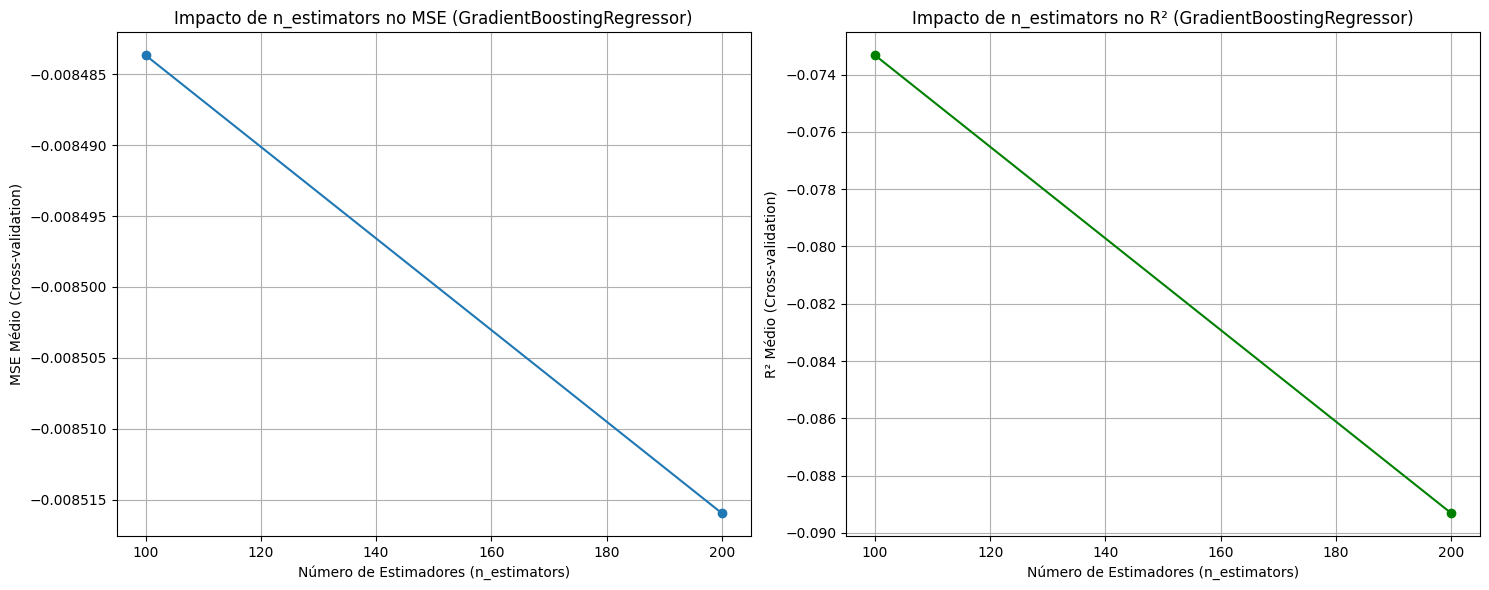

In [ ]:
# ==============================================================================
# VISUALIZAÇÃO DOS RESULTADOS DO GRIDSEARCHCV PARA REGRESSÃO
# ==============================================================================

# Obtém os resultados do GridSearchCV para o melhor modelo
# O nome do melhor modelo é armazenado em best_model_name na célula anterior
results = cv_results_all[best_model_name]

# Verifica se o melhor modelo é um modelo baseado em árvores (que tem n_estimators)
if 'n_estimators' in best_models[best_model_name].named_steps['clf'].get_params():
    try:
        # Tenta acessar o parâmetro n_estimators. O nome da chave pode variar dependendo de como foi definido no param_grid e pipeline.
        # Vamos tentar algumas variações comuns de nomes de chaves de parâmetro
        param_key = None
        for key in results.keys():
            if key.endswith('__n_estimators'):
                 param_key = key
                 break

        if param_key:
            results_mse = pd.DataFrame({
                'param_n_estimators': results[param_key],
                'mean_test_mse': results['mean_test_mse'] * -1 # MSE is negative in scikit-learn, so multiply by -1
            })

            results_r2 = pd.DataFrame({
                'param_n_estimators': results[param_key],
                'mean_test_r2': results['mean_test_r2']
            })

            # Agrupa por n_estimators e calcula a média (se outros parâmetros variam)
            results_mse_agg = results_mse.groupby('param_n_estimators')['mean_test_mse'].mean().reset_index()
            results_r2_agg = results_r2.groupby('param_n_estimators')['mean_test_r2'].mean().reset_index()


            # PLOTANDO OS RESULTADOS
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))

            # Plot para Mean Squared Error (MSE)
            axes[0].plot(results_mse_agg['param_n_estimators'], results_mse_agg['mean_test_mse'], marker='o')
            axes[0].set_xlabel('Número de Estimadores (n_estimators)')
            axes[0].set_ylabel('MSE Médio (Cross-validation)')
            axes[0].set_title(f'Impacto de n_estimators no MSE ({best_model_name})')
            axes[0].grid(True)

            # Plot para R-squared (R²)
            axes[1].plot(results_r2_agg['param_n_estimators'], results_r2_agg['mean_test_r2'], marker='o', color='green')
            axes[1].set_xlabel('Número de Estimadores (n_estimators)')
            axes[1].set_ylabel('R² Médio (Cross-validation)')
            axes[1].set_title(f'Impacto de n_estimators no R² ({best_model_name})')
            axes[1].grid(True)

            plt.tight_layout()
            plt.show()
        else:
             print(f"Não foi possível encontrar a chave do parâmetro 'n_estimators' nos resultados do GridSearchCV para {best_model_name}.")


    except KeyError as e:
        print(f"Erro ao plotar resultados para {best_model_name}: Chave ausente - {e}. Verifique os resultados do cv_results_all.")
        print("Keys disponíveis nos resultados:", results.keys())

elif best_model_name == 'SVR':
    print(f"Visualização da evolução do GridSearchCV para {best_model_name} (SVR) não implementada da mesma forma. Considere analisar os resultados diretamente em cv_results_all['SVR'].")

else:
    print(f"Visualização da evolução do GridSearchCV para o modelo {best_model_name} não implementada.")

In [ ]:
# --- 2. AVALIAÇÃO DOS MODELOS ---

# Cria uma lista para armazenar os resultados da avaliação
evaluation_results = []

print("\n--- Avaliação dos Modelos no Conjunto de Teste ---")

# Itera sobre cada modelo treinado no GridSearchCV
for name, trained_model in best_models.items():
    # Faz previsões no conjunto de teste usando o modelo treinado (que inclui o scaler)
    y_pred = trained_model.predict(X_test)

    # Calcula as métricas de erro para regressão
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nModelo: {name}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

    # Armazena os resultados
    evaluation_results.append({
        'Modelo': name,
        'MAE': mae,
        'R²': r2
    })

# Cria um DataFrame com os resultados da avaliação
test_results_df = pd.DataFrame(evaluation_results)

print("\n--- Resumo da Avaliação (DataFrame) ---")
display(test_results_df)


--- Avaliação dos Modelos no Conjunto de Teste ---

Modelo: RandomForestRegressor
Mean Absolute Error (MAE): 0.0098
R-squared (R²): -0.1485

Modelo: SVR
Mean Absolute Error (MAE): 0.0150
R-squared (R²): 0.0485

Modelo: GradientBoostingRegressor
Mean Absolute Error (MAE): 0.0112
R-squared (R²): 0.1276

--- Resumo da Avaliação (DataFrame) ---


,Modelo,MAE,R²
0,RandomForestRegressor,0.009804,-0.148506
1,SVR,0.014951,0.048475
2,GradientBoostingRegressor,0.011205,0.127617


## Matriz de Confusão

In [ ]:
# --- Visualização de Matrizes de Confusão (para fins de demonstração com classificação) ---
# NOTA: Este trecho é para DEMONSTRAR matrizes de confusão, que são para CLASSIFICAÇÃO.
# O problema principal de prever o potencial é de REGRESSÃO.

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Certifique-se que pandas está importado

# 1. Criar uma variável alvo CATEGÓRICA para fins de CLASSIFICAÇÃO
# Vamos discretizar o 'potencial_score' em categorias (Ex: Baixo, Médio, Alto)
# Ajustando os limites (bins) para tentar garantir pelo menos 2 exemplos por classe
# Primeiro, vamos olhar a distribuição do potencial_score para definir melhor os bins
print("--- Estatísticas do potencial_score ---")
print(df_modelo['potencial_score'].describe())

# Tentativa 1: Bins baseados nos quartis para garantir uma distribuição mais uniforme
# bins = df_modelo['potencial_score'].quantile([0, 0.33, 0.66, 1]).tolist() # Quartis não são ideais para 3 classes
# labels = ['Baixo Potencial', 'Médio Potencial', 'Alto Potencial']

# Tentativa 2: Ajustando manualmente com base nas estatísticas, ou usando um número fixo de bins
n_bins = 3
# Use pd.cut com um número fixo de bins para garantir o número correto de arestas para os rótulos
# Isso é mais robusto para distribuições com muitos valores duplicados.
# labels = ['Baixo Potencial', 'Médio Potencial', 'Alto Potencial'] # Define labels explicitly

# Checking if labels were defined before pd.cut
if 'labels' not in locals():
    labels = [f'Categoria {i+1}' for i in range(n_bins)] # Default labels if not defined

df_modelo['potencial_category'] = pd.cut(df_modelo['potencial_score'], bins=n_bins, labels=labels, include_lowest=True)


print("\n--- Limites dos Bins Criados ---")
# Display the bins created by pd.cut
print(df_modelo['potencial_category'].cat.categories) # Print the category labels as bins are implicitly defined


# Remover linhas com categorias NaN se houver (pode acontecer com duplicates='drop' se houver poucos valores únicos)
df_modelo.dropna(subset=['potencial_category'], inplace=True)

# Verificar a contagem de exemplos em cada categoria APÓS discretização e dropna
print("\n--- Contagem de Exemplos por Categoria ---")
print(df_modelo['potencial_category'].value_counts())


# Preparar dados para um modelo de CLASSIFICAÇÃO SIMPLES
# Usaremos as mesmas features, mas a nova variável alvo categórica
features = [col for col in X.columns if col != 'geometry'] # Reutiliza as features numéricas usadas para regressão, excluindo geometry se estiver presente
X_cls = df_modelo[features]
y_cls = df_modelo['potencial_category']

# Dividir dados para CLASSIFICAÇÃO
# Verifique se todas as classes em y_cls têm pelo menos 2 amostras antes de usar stratify
if y_cls.value_counts().min() >= 2:
    X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
        X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls # Usar stratify para manter proporção das categorias
    )
    print("\nDados divididos com estratificação.")
else:
     print("\nDados divididos SEM estratificação (número insuficiente de amostras em uma classe para estratificar).")
     X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
        X_cls, y_cls, test_size=0.2, random_state=42
    )


# 2. Treinar um modelo de CLASSIFICAÇÃO (Ex: RandomForestClassifier)
print("\nTreinando um modelo RandomForestClassifier para demonstrar matriz de confusão...")
classifier_model = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_model.fit(X_train_cls, y_train_cls)
print("Treinamento do classificador concluído!")

# 3. Fazer previsões no conjunto de teste de CLASSIFICAÇÃO
y_pred_cls = classifier_model.predict(X_test_cls)

# 4. Gerar a Matriz de Confusão
# Garante que todos os rótulos possíveis estejam presentes na matriz
all_labels = y_cls.cat.categories.tolist()
cm = confusion_matrix(y_test_cls, y_pred_cls, labels=all_labels)

# 5. Visualizar a Matriz de Confusão
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Matriz de Confusão (Demonstração - Classificação do Potencial)', fontsize=14)
plt.xlabel("Categoria Predita")
plt.ylabel("Categoria Real")
plt.grid(False) # Matrizes de confusão geralmente não usam grid
plt.show()

print("\n--- Relatório de Classificação (Demonstração) ---")
# Você pode adicionar um classification_report aqui se quiser mais métricas de classificação
from sklearn.metrics import classification_report
print(classification_report(y_test_cls, y_pred_cls, target_names=all_labels, labels=all_labels, zero_division=0))

# NOTA: Lembre-se que esta classificação é APENAS para demonstrar a matriz de confusão.
# A análise principal do potencial energético deve usar os resultados dos modelos de REGRESSÃO.

--- Estatísticas do potencial_score ---


NameError: name 'df_modelo' is not defined

In [ ]:
# --- 3. ANÁLISE DA IMPORTÂNCIA DAS FEATURES ---

# Extrai a importância de cada feature do modelo treinado.
importances = model.feature_importances_

# Cria um DataFrame para visualizar melhor a importância de cada feature.
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Importância das Features ---")
print(feature_importance_df)


--- Importância das Features ---
                Feature  Importance
3      num_total_usinas    0.765157
4     potencia_total_mw    0.102752
2          centroid_lat    0.060686
0              area_km2    0.044327
1          centroid_lon    0.027079
5  radiacao_media_anual    0.000000


/tmp/ipython-input-1703122656.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


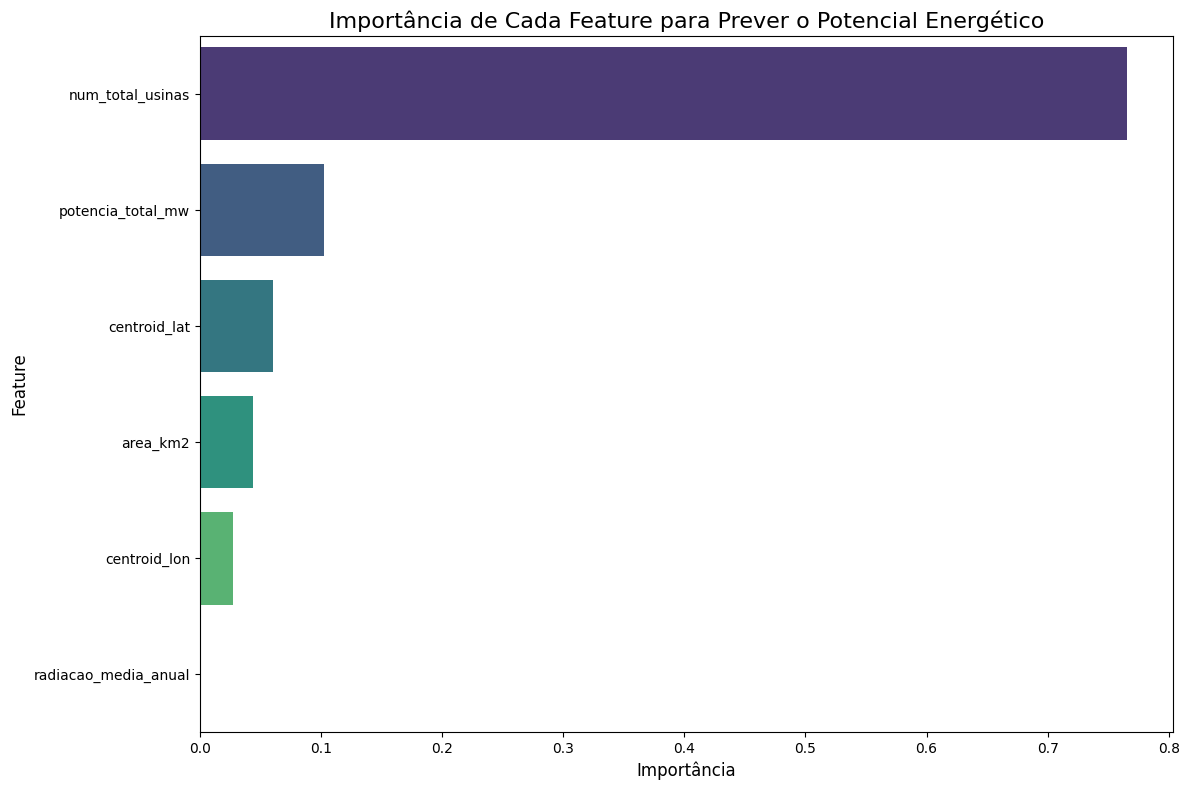

In [ ]:
# Cria um gráfico de barras para visualizar a importância.
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Importância de Cada Feature para Prever o Potencial Energético', fontsize=16)
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
# Salva a imagem para que possa ser exibida no notebook.
plt.savefig('feature_importance.png')


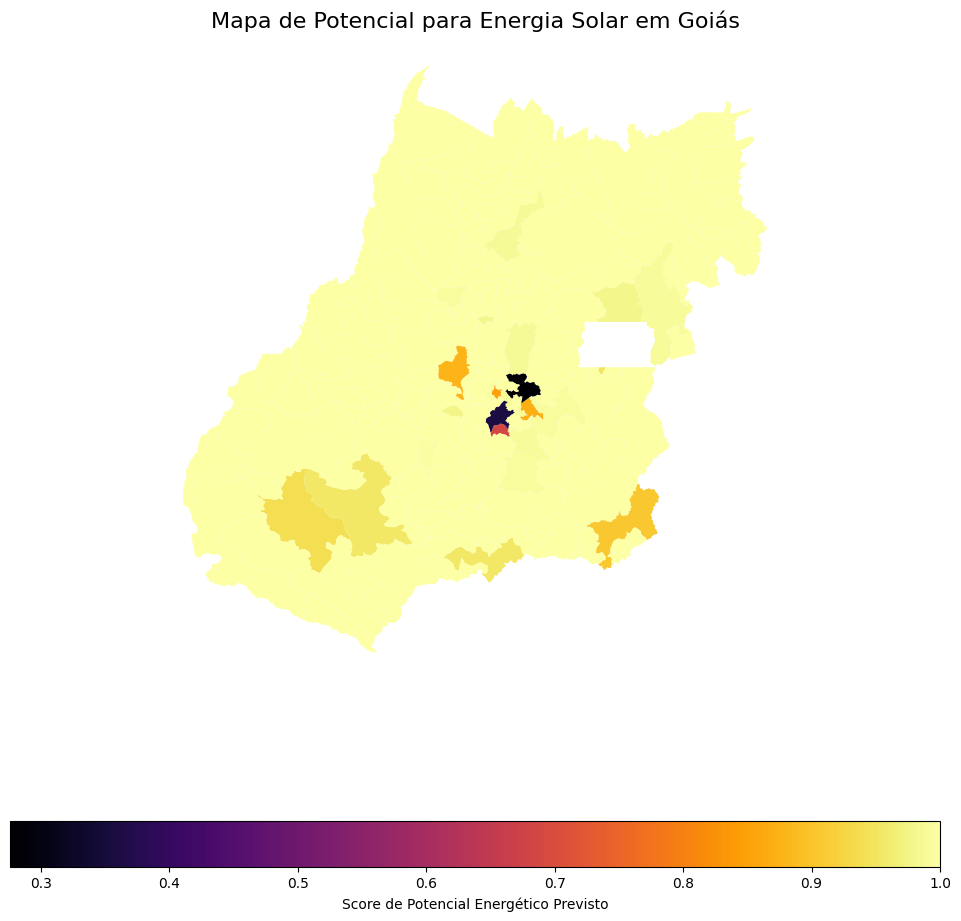

In [ ]:
# --- 4. VISUALIZAÇÃO FINAL: MAPA DE POTENCIAL DE GOIÁS ---

# Usa o modelo treinado para prever o potencial de TODOS os municípios.
df_modelo['predicted_potential'] = model.predict(df_modelo[features])

# Cria o mapa coroplético (mapa de calor).
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
df_modelo.plot(column='predicted_potential',
               ax=ax,
               legend=True,
               cmap='inferno',
               legend_kwds={'label': "Score de Potencial Energético Previsto",
                            'orientation': "horizontal"})

# Remove os eixos para uma visualização mais limpa.
ax.set_axis_off()
ax.set_title('Mapa de Potencial para Energia Solar em Goiás', fontdict={'fontsize': '16', 'fontweight': '3'})
plt.savefig('mapa_potencial_goias.png')

In [ ]:
# Supondo que 'df_modelo' seja seu DataFrame final, após o Passo 6
ranking_potencial_solar = df_modelo[['nm_mun', 'predicted_potential']].sort_values(
    by='predicted_potential',
    ascending=False
)

print("Ranking dos Municípios com Maior Potencial para Energia Solar:")
print(ranking_potencial_solar.head(10))

Ranking dos Municípios com Maior Potencial para Energia Solar:
                    nm_mun  predicted_potential
0   São Francisco de Goiás                  1.0
1       Palestina de Goiás                  1.0
2              Goianápolis                  1.0
3                  Diorama                  1.0
4                   Rialma                  1.0
6             Campos Belos                  1.0
18             Nova Aurora                  1.0
7              Maurilândia                  1.0
9            Campos Verdes                  1.0
10            Damianópolis                  1.0


/tmp/ipython-input-3121901113.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


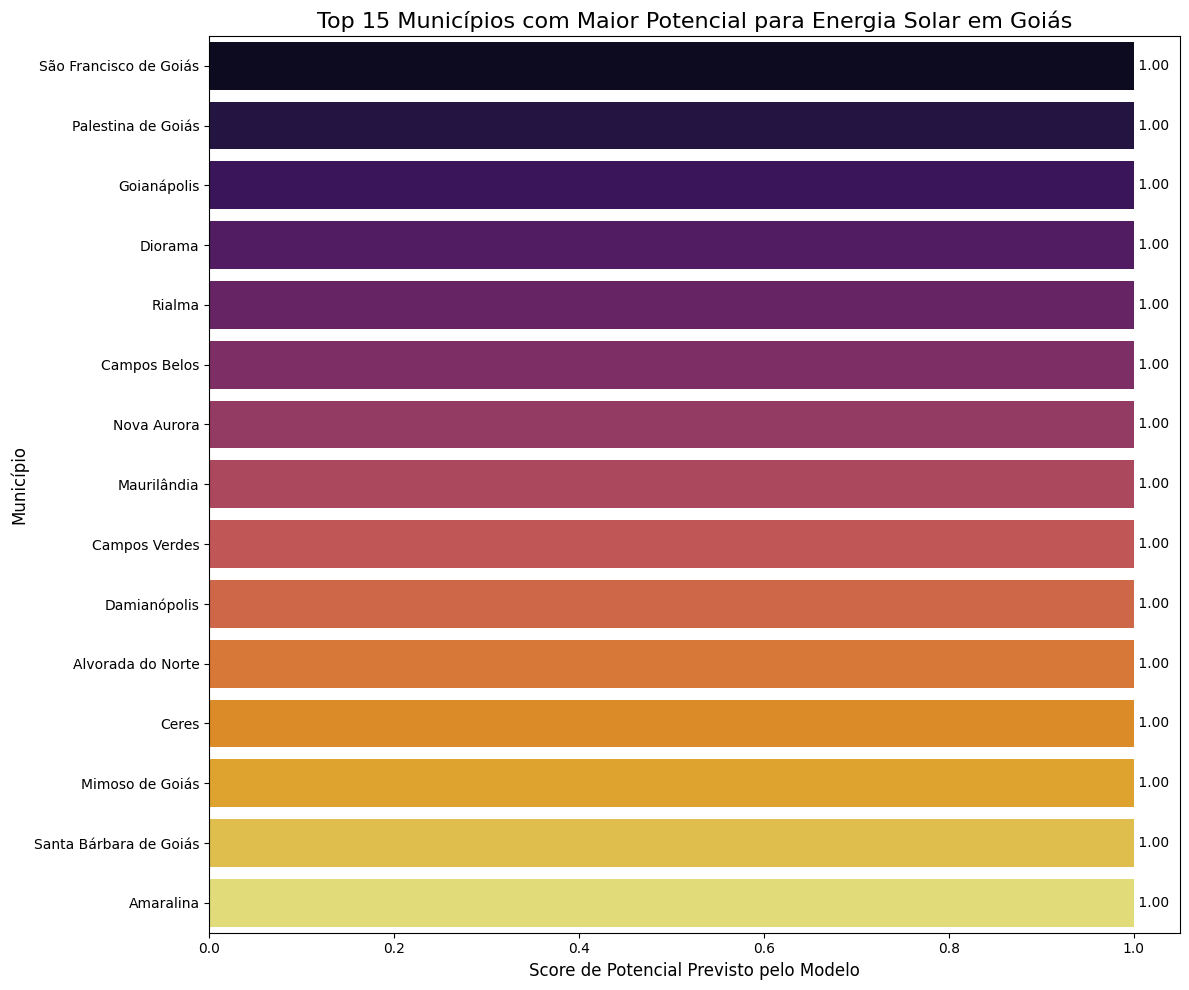

In [ ]:
top_municipios = ranking_potencial_solar.head(15)

plt.figure(figsize=(12, 10))

# Cria o gráfico de barras horizontal
# Usamos a paleta 'inferno' para manter a consistência visual com o mapa de calor
barplot = sns.barplot(
    x='predicted_potential',
    y='nm_mun',
    data=top_municipios,
    palette='inferno'
)

# Adiciona os valores exatos no final de cada barra para facilitar a leitura
for index, value in enumerate(top_municipios['predicted_potential']):
    plt.text(value, index, f' {value:.2f}', va='center')

# Adiciona títulos e rótulos descritivos
plt.title('Top 15 Municípios com Maior Potencial para Energia Solar em Goiás', fontsize=16)
plt.xlabel('Score de Potencial Previsto pelo Modelo', fontsize=12)
plt.ylabel('Município', fontsize=12)

# Ajusta o layout para garantir que nada seja cortado
plt.tight_layout()

# Salva o gráfico como uma imagem de alta qualidade para usar em sua apresentação
plt.savefig('ranking_potencial_solar.png')

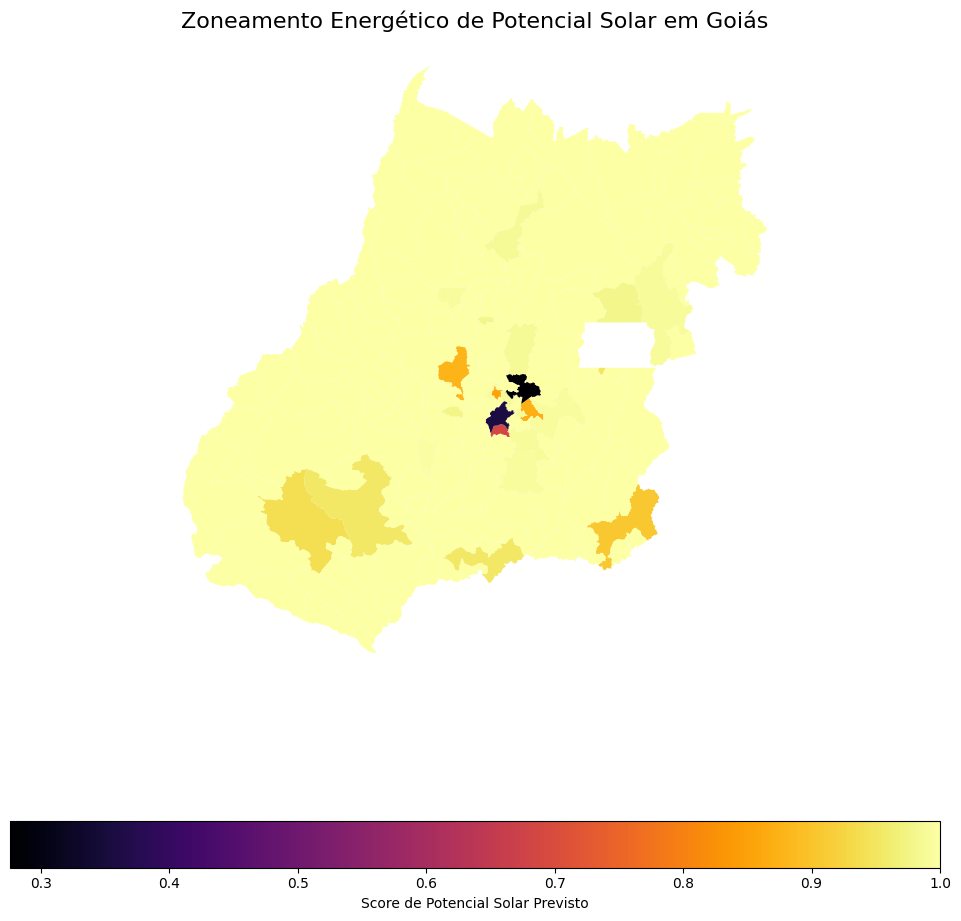

Top 10 Municípios para Investimento em Energia Solar:
                    nm_mun  predicted_potential
0   São Francisco de Goiás                  1.0
1       Palestina de Goiás                  1.0
2              Goianápolis                  1.0
3                  Diorama                  1.0
4                   Rialma                  1.0
6             Campos Belos                  1.0
18             Nova Aurora                  1.0
7              Maurilândia                  1.0
9            Campos Verdes                  1.0
10            Damianópolis                  1.0


In [ ]:
# Geração do Mapa de Zoneamento
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
df_modelo.plot(column='predicted_potential', ax=ax, legend=True, cmap='inferno',
               legend_kwds={'label': "Score de Potencial Solar Previsto", 'orientation': "horizontal"})
ax.set_axis_off()
ax.set_title('Zoneamento Energético de Potencial Solar em Goiás', fontsize=16)
plt.show()

# Geração do Ranking para Políticas Públicas
ranking_potencial_solar = df_modelo[['nm_mun', 'predicted_potential']].sort_values(by='predicted_potential', ascending=False)
print("Top 10 Municípios para Investimento em Energia Solar:")
print(ranking_potencial_solar.head(10))

# (O código para o gráfico de barras também entra aqui)

In [ ]:
# (Requer a coluna 'potencia_hidro_mw' calculada no Passo 2)
limiar_potencial = df_modelo['predicted_potential'].quantile(0.75) # Top 25% em potencial
limiar_potencia_hidro = df_modelo['potencia_hidro_mw'].quantile(0.75) # Top 25% em potência hídrica

zonas_de_sinergia = df_modelo[
    (df_modelo['predicted_potential'] >= limiar_potencial) &
    (df_modelo['potencia_hidro_mw'] >= limiar_potencia_hidro)
]

print("Municípios com Maior Sinergia Hidro-Solar (Prioridade Máxima):")
print(zonas_de_sinergia[['nm_mun', 'predicted_potential', 'potencia_hidro_mw']])

Municípios com Maior Sinergia Hidro-Solar (Prioridade Máxima):
                     nm_mun  predicted_potential  potencia_hidro_mw
0    São Francisco de Goiás                  1.0                0.0
1        Palestina de Goiás                  1.0                0.0
2               Goianápolis                  1.0                0.0
3                   Diorama                  1.0                0.0
4                    Rialma                  1.0                0.0
..                      ...                  ...                ...
239          Pilar de Goiás                  1.0                0.0
240          Padre Bernardo                  1.0                0.0
242                  Aruanã                  1.0                0.0
243                   Itajá                  1.0                0.0
244    Morro Agudo de Goiás                  1.0                0.0

[204 rows x 3 columns]
